## Load dataset

In [1]:
import torch, torchaudio

C:\Users\Simone\anaconda3\envs\reprodl\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
torch.cuda.is_available()

True

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
datapath = Path('data/ESC-50-master')

In [5]:
data = pd.read_csv(datapath / Path('meta/esc50.csv'))

In [6]:
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
xb, sample_rate = torchaudio.load(datapath / 'audio' / f'{data.iloc[0, 0]}')

torch.Size([1, 220500])
44100


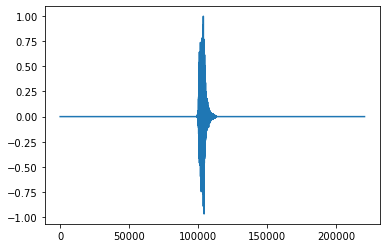

In [8]:
print(xb.shape)
print(sample_rate)
plt.plot(xb[0].numpy())

In [9]:
xb.max()

tensor(0.9988)

torch.Size([1, 128, 431])


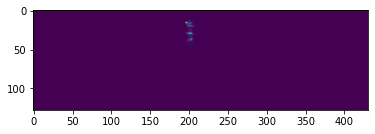

In [10]:
specgram = torchaudio.transforms.MelSpectrogram(n_fft=2048, hop_length=512, n_mels=128, f_min=20, f_max=8300)(xb)
print(specgram.size())
plt.imshow(specgram[0].numpy())

In [11]:
class CS50Dataset(torch.utils.data.Dataset):

    def __init__(self, datapath : Path, fold : int, sample_rate=8000):
        self.datapath = datapath
        self.csv = pd.read_csv(datapath / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'] == fold]
        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)
        self.power_to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
    def __getitem__(self, index):
        
        xb, sample_rate = torchaudio.load(self.datapath / 'audio' / f'{self.csv.iloc[index, 0]}')
        yb = self.csv.iloc[0, 2]

        sound = self.resample(xb)
        sound = self.mel(sound)
        return self.power_to_db(sound), yb
    
    def __len__(self):
        return len(self.csv)

In [12]:
traindata = CS50Dataset(datapath, 1)
testdata = CS50Dataset(datapath, 2)

In [13]:
xb, yb = traindata[0]

torch.Size([1, 128, 201])


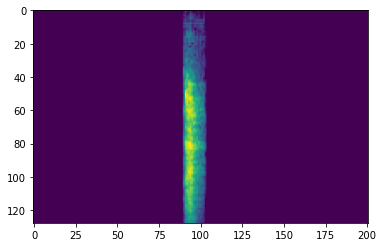

In [14]:
print(xb.shape)
plt.imshow(xb[0].numpy())

In [15]:
train_loader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)

In [16]:
test_loader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=False)

In [17]:
for xb, yb in train_loader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([32, 1, 128, 201])
torch.Size([32])


## Build model

In [18]:
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as ptl

In [19]:
class AudioNet(ptl.LightningModule):
    
    def __init__(self, n_classes=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Can basically copy from here for the moment:
        # https://pytorch-lightning.readthedocs.io/en/latest/starter/new-project.html
        xb, yb = batch
        y_pred = self(xb)
        loss = F.cross_entropy(y_pred, yb)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [20]:
audionet = AudioNet()

In [21]:
audionet = audionet.to('cuda')
xb = xb.to('cuda')

In [23]:
audionet(xb).shape

torch.Size([32, 50])

In [24]:
trainer = ptl.Trainer(gpus=1, default_root_dir=Path('data/trainlogs/'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [25]:
trainer.fit(audionet, train_loader, test_loader)

C:\Users\Simone\anaconda3\envs\reprodl\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 15.6 K
1  | bn1   | BatchNorm2d | 256   
2  | conv2 | Conv2d      | 147 K 
3  | bn2   | BatchNorm2d | 256   
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 295 K 
6  | bn3   | BatchNorm2d | 512   
7  | conv4 | Conv2d      | 1.2 M 
8  | bn4   | BatchNorm2d | 1.0 K 
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 25.7 K
---------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.665     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\Simone\anaconda3\envs\reprodl\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1